In [1]:
import pandas as pd
import json as json
from pandas import json_normalize
import os
import numpy as np
import csv
from matplotlib import pyplot as plt

import keras
import tensorflow as tf
from keras.layers import Input, Flatten, Dense, Lambda, Reshape, Dropout
from keras.layers import BatchNormalization
from keras.models import Model
from keras.losses import binary_crossentropy
from keras.metrics import mse, accuracy
from keras.callbacks import ReduceLROnPlateau
from keras import backend as K

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

keras.backend.clear_session()

srcDir = "../data/preprocessed/"
model_path = srcDir + "models/model_1000split_balanced/"

if not os.path.isdir(model_path):
    os.mkdir(model_path)
if not os.path.isdir(model_path + "plots/"):
    os.mkdir(model_path + "plots/")

In [2]:
# Load cleaned data

with open(srcDir + "normalized_smoothed_data.csv", 'r') as f:
    data = list(csv.reader(f))

df = pd.DataFrame(data[1:], columns=data[0])
df = df.drop(columns=["real_height","datum","smoothed_heigth"])
df["container_Id"] = df["container_id"]
df.drop(columns=["container_id"], inplace=True)
df.to_csv(os.path.join(srcDir, "training_data.csv"), index=False)
df.head()

,height_delta,temperatur_in_grad,niederschlag_in_mm,ist_industriegebiet,ist_wohngebiet,ist_feiertag,sekunde,minute,stunde,wochentag,...,DEVEUI_70B3D50070001779,DEVEUI_70B3D5007000177C,DEVEUI_70B3D50070001780,DEVEUI_70B3D50070001781,DEVEUI_70B3D50070001782,DEVEUI_70B3D50070001786,DEVEUI_70B3D50070001787,DEVEUI_70B3D50070001788,DEVEUI_70B3D50070001789,container_Id
0,0.0,0.33333334,0.0,0.0,1.0,0.0,0.2542373,0.84745765,0.0,0.8333333,...,0,0,0,0,0,0,0,0,1,77
1,0.0,0.28787878,0.0,0.0,1.0,0.0,0.2542373,0.84745765,0.04347826,0.8333333,...,0,0,0,0,0,0,0,0,1,77
2,0.0,0.28787878,0.0,0.0,1.0,0.0,0.2542373,0.84745765,0.08695652,0.8333333,...,0,0,0,0,0,0,0,0,1,77
3,0.0,0.28787878,0.0,0.0,1.0,0.0,0.2542373,0.84745765,0.13043478,0.8333333,...,0,0,0,0,0,0,0,0,1,77
4,0.0,0.28787878,0.0,0.0,1.0,0.0,0.2542373,0.84745765,0.17391305,0.8333333,...,0,0,0,0,0,0,0,0,1,77


In [3]:
df.keys()

Index(['height_delta', 'temperatur_in_grad', 'niederschlag_in_mm',
       'ist_industriegebiet', 'ist_wohngebiet', 'ist_feiertag', 'sekunde',
       'minute', 'stunde', 'wochentag', 'kalenderwoche', 'monat', 'jahr',
       'farbe_brown', 'farbe_green', 'farbe_white', 'unix_time', 'ist_ferien',
       'laengengrad', 'breitengrad', 'year', 'DEVEUI_70B3D500700016DA',
       'DEVEUI_70B3D500700016DE', 'DEVEUI_70B3D500700016DF',
       'DEVEUI_70B3D500700016E0', 'DEVEUI_70B3D500700016E5',
       'DEVEUI_70B3D500700016E6', 'DEVEUI_70B3D500700016E7',
       'DEVEUI_70B3D500700016EB', 'DEVEUI_70B3D500700016EE',
       'DEVEUI_70B3D500700016F1', 'DEVEUI_70B3D500700016F2',
       'DEVEUI_70B3D500700016F4', 'DEVEUI_70B3D500700016F6',
       'DEVEUI_70B3D500700016F7', 'DEVEUI_70B3D500700016FA',
       'DEVEUI_70B3D500700016FC', 'DEVEUI_70B3D50070001700',
       'DEVEUI_70B3D50070001701', 'DEVEUI_70B3D50070001704',
       'DEVEUI_70B3D50070001706', 'DEVEUI_70B3D50070001708',
       'DEVEUI_70B3D500

In [4]:
df = df.loc[df["container_Id"] == "1"]
df = df["height_delta"]
df = pd.DataFrame(df.values.tolist(), columns=["height_delta"])
df

,height_delta
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
7301,0.10144926
7302,0.04347826
7303,0.1014493
7304,0.07246378


In [5]:
df["index"] = 0
df = df.astype({"index": "float32"})
for x in range(len(df)):
    df["index"][x] = x / 7305
df

<ipython-input-5-befba8adc8fd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["index"][x] = x / 7305


,height_delta,index
0,0.0,0.000000
1,0.0,0.000137
2,0.0,0.000274
3,0.0,0.000411
4,0.0,0.000548
...,...,...
7301,0.10144926,0.999452
7302,0.04347826,0.999589
7303,0.1014493,0.999726
7304,0.07246378,0.999863


In [6]:
# exclude column "container_Id" at the end of dataframe
data = np.array(df.values.tolist())
data

array([['0.0', '0.0'],
       ['0.0', '0.000136892544105649'],
       ['0.0', '0.000273785088211298'],
       ...,
       ['0.1014493', '0.9997262358665466'],
       ['0.07246378', '0.9998630881309509'],
       ['0.03623189', '1.0']], dtype='<U20')

In [7]:
# exclude every thrid sample from the training set
train = []
val = []

counter = 0
drop_rate = 1000

for x in range(len(data)):
    if counter % drop_rate == 0:
        val.append(data[x])
        counter = 0
    else:
        train.append(data[x])
    
    counter = counter + 1

In [8]:
print(len(train))
print(len(val))

train = np.array(train).astype("float32")
val = np.array(val).astype("float32")

7298
8


In [9]:
x_train = train[:, 1:]
y_train = train[:, 0]

In [10]:
x_val = val[:, 1:]
y_val = val[:, 0]

In [11]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)


(7298, 1)
(7298,)
(8, 1)
(8,)


In [12]:
#
input_dim = x_train[0].shape
input_size = len(x_train[0])
batch_size = 128
no_epochs = 50
validationsplit=0.1
dropout = 0.0

In [13]:
# # # Model # #
# i = Input(shape=input_dim, name="input_layer")
# x = Dense(input_size + 40, activation="relu")(i)
# x = BatchNormalization()(x)
# x = Dense(input_size + 80, activation="relu")(x)
# x = BatchNormalization()(x)
# x = Dense(input_size + 120, activation="relu")(x)
# x = BatchNormalization()(x)
# x = Dense(input_size + 200, activation="relu")(x)
# x = BatchNormalization()(x)
# x = Dense(input_size + 300, activation="relu")(x)
# x = BatchNormalization()(x)
# x = Dense(input_size + 380, activation="relu")(x)
# x = BatchNormalization()(x)
# x = Dense(input_size + 350, activation="relu")(x)
# x = BatchNormalization()(x)
# x = Dense(input_size + 280, activation="relu")(x)
# x = BatchNormalization()(x)
# x = Dense(input_size + 200, activation="relu")(x)
# x = BatchNormalization()(x)
# x = Dense(input_size + 100, activation="relu")(x)
# x = BatchNormalization()(x)
# x = Dense(input_size + 50, activation="relu")(x)
# x = BatchNormalization()(x)
# x = Dense(70, activation="relu")(x)
# x = BatchNormalization()(x)
# x = Dense(40, activation="relu")(x)
# x = BatchNormalization()(x)
# x = Dense(15, activation="relu")(x)
# x = BatchNormalization()(x)
# o = Dense(1, name="ouput_layer")(x)

# fc_model = Model(i,o, name="fc_model")
# fc_model.summary()

In [51]:
# # Model # #
i = Input(shape=input_dim, name="input_layer")
x = Dense(5, activation="relu")(i)
x = BatchNormalization()(x)
x = Dense(10, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(20, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(50, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(50, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(40, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(20, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(10, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(5, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(5, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(5, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(5, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(5, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(5, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(3, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(2, activation="relu")(x)
# x = BatchNormalization()(x)
o = Dense(1, name="ouput_layer")(x)

fc_model = Model(i,o, name="fc_model")
fc_model.summary()

Model: "fc_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1)]               0         
_________________________________________________________________
dense_152 (Dense)            (None, 5)                 10        
_________________________________________________________________
batch_normalization_136 (Bat (None, 5)                 20        
_________________________________________________________________
dense_153 (Dense)            (None, 10)                60        
_________________________________________________________________
batch_normalization_137 (Bat (None, 10)                40        
_________________________________________________________________
dense_154 (Dense)            (None, 20)                220       
_________________________________________________________________
batch_normalization_138 (Bat (None, 20)                80 

In [52]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, verbose=1,
                              patience=5, min_lr=0.0000001, min_delta=0.001)
#default value lr = 0.001

In [53]:
callbacks = [reduce_lr]

In [54]:
fc_model.compile(optimizer='adam', loss=mse,  metrics=["mae", "accuracy"])

# Train autoencoder
history = fc_model.fit(x_train, y_train, 
                  epochs = no_epochs,
                  shuffle=True,
                  batch_size = batch_size, 
                  validation_data=(x_val, y_val),
                  callbacks=callbacks)

Epoch 1/50
58/58 [==============================] - 21s 77ms/step - loss: 0.3553 - mae: 0.3832 - accuracy: 0.5952 - val_loss: 0.0014 - val_mae: 0.0355 - val_accuracy: 0.5000
Epoch 2/50
58/58 [==============================] - 2s 37ms/step - loss: 0.0589 - mae: 0.1312 - accuracy: 0.5946 - val_loss: 0.0040 - val_mae: 0.0615 - val_accuracy: 0.5000
Epoch 3/50
58/58 [==============================] - 2s 37ms/step - loss: 0.0200 - mae: 0.0796 - accuracy: 0.6102 - val_loss: 0.0059 - val_mae: 0.0755 - val_accuracy: 0.5000
Epoch 4/50
58/58 [==============================] - 2s 37ms/step - loss: 0.0100 - mae: 0.0613 - accuracy: 0.5848 - val_loss: 0.0049 - val_mae: 0.0694 - val_accuracy: 0.5000
Epoch 5/50
58/58 [==============================] - 2s 38ms/step - loss: 0.0056 - mae: 0.0481 - accuracy: 0.5803 - val_loss: 0.0061 - val_mae: 0.0695 - val_accuracy: 0.5000
Epoch 6/50
58/58 [==============================] - 2s 37ms/step - loss: 0.0042 - mae: 0.0422 - accuracy: 0.5798 - val_loss: 0.0037 - 

58/58 [==============================] - 2s 37ms/step - loss: 0.0011 - mae: 0.0241 - accuracy: 0.6000 - val_loss: 0.0022 - val_mae: 0.0332 - val_accuracy: 0.5000
Epoch 46/50
58/58 [==============================] - 2s 38ms/step - loss: 0.0011 - mae: 0.0247 - accuracy: 0.6038 - val_loss: 8.7251e-04 - val_mae: 0.0260 - val_accuracy: 0.5000
Epoch 47/50
58/58 [==============================] - 2s 37ms/step - loss: 0.0011 - mae: 0.0249 - accuracy: 0.5844 - val_loss: 6.3672e-04 - val_mae: 0.0199 - val_accuracy: 0.5000
Epoch 48/50
58/58 [==============================] - 2s 37ms/step - loss: 0.0012 - mae: 0.0257 - accuracy: 0.5892 - val_loss: 0.0019 - val_mae: 0.0322 - val_accuracy: 0.5000
Epoch 49/50
58/58 [==============================] - 2s 38ms/step - loss: 0.0011 - mae: 0.0249 - accuracy: 0.5808 - val_loss: 7.7721e-04 - val_mae: 0.0246 - val_accuracy: 0.5000
Epoch 50/50
58/58 [==============================] - 2s 38ms/step - loss: 0.0011 - mae: 0.0239 - accuracy: 0.5987 - val_loss: 9.62

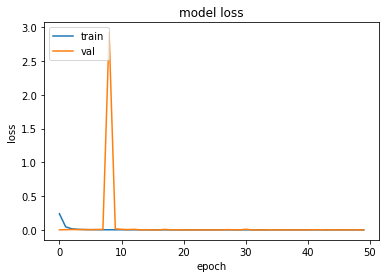

In [55]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(model_path + "plots/model_los.svg")
plt.show()

In [56]:
plt.close
# 254 is max height
# 134 is max delta hight

multiplier = 134

def prediction(index, x_set, y_set):
    data_point = np.array([x_set[index]])
    pred_height = fc_model.predict(data_point)[0][0] * multiplier
    real_height = y_set[index] * multiplier
    
    print("Real value: ", real_height, " estimated: ", pred_height)
    
def prediction_Plot(x_set, y_set, num):
    index_list = np.linspace(0, len(x_set)-1, num).astype("int")
    #print(index_list)
    pred_list = []
    sum_heigth = 0.0
    for x in index_list:
        data_point = np.array([x_set[x]])
        pred_height = fc_model.predict(data_point)[0][0] * multiplier
        real_height = y_set[x] * multiplier
        pred_list.append(abs(pred_height - real_height))
        sum_heigth = sum_heigth + abs(pred_height - real_height)
        
    print("Average absolute error in ", num, " data points: " , sum_heigth / num)
    plt.plot(pred_list)
    plt.ylabel('total Error')
    plt.savefig(model_path + "plots/Prediction_plot.svg")
    plt.show()

In [57]:
prediction(2, x_val, y_val)

Real value:  3.88405429944396  estimated:  1.9649063497781754


Average absolute error in  1000  data points:  3.5172124190842733


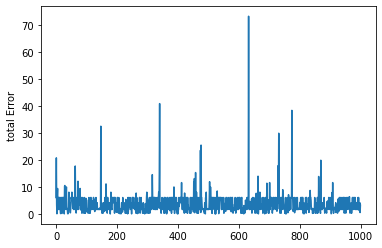

In [58]:
prediction_Plot(x_train, y_train, 1000)

In [59]:
fc_model.save(model_path + "model")

INFO:tensorflow:Assets written to: ../data/preprocessed/models/model_1000split_balanced/model/assets


In [60]:
data_in = df.values.tolist()
data_in = np.array(data_in).astype("float32")
data_in = data_in[:, 0]
len(data_in)

7306

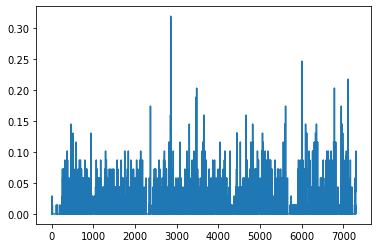

In [61]:
plt.plot(data_in)

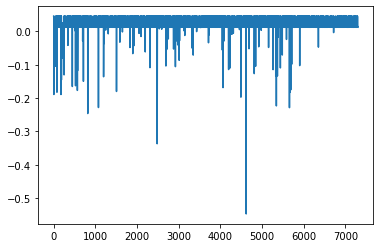

In [62]:
data_in = df.values.tolist()
data_in = df.values.tolist()
data_in = np.array(data_in).astype("float32")
data_in = data_in[:, 1]

pp = []
for x in range(len(data_in)):
    data_point = np.array([data_in[x]])
    pred_height = fc_model.predict(data_point)[0][0]
    pp.append(pred_height)
pp = np.array(pp).astype("float32")
plt.plot(pp)